# Run 2

In [2]:
from matplotlib.axes import Axes
from metric import Metrics

import matplotlib.pyplot as plt
import numpy as np
import os

METRICS= ["precision", "recall", "average_degree", "average_smooth", "average_sparsity"]

def plot_single(axes:Axes, train_metric:np.ndarray=None, val_metric:np.ndarray=None, test_metric:np.ndarray=None, metric_name:str="Metric", show:str='none', start_check:int|float=0.2, marker:bool=False, best_k:int=3, higher_is_better:bool=False):
    _= axes.plot(train_metric, label="train", marker=marker)
    _= axes.plot(val_metric,   label="val",   marker=marker)
    
    if isinstance(start_check, float):
        start_check= round(start_check*len(train_metric))
    
    val_ascending_indeces= np.argsort(val_metric[start_check:]) + start_check
    best_k_indeces= val_ascending_indeces[-best_k:] if higher_is_better else val_ascending_indeces[:best_k]
    
    color= None
    if (show in ['full', 'both']):
        plot_object= axes.plot(test_metric, label="test", marker=marker)
        color = plot_object[0].get_color()
    if (show in ['points', 'both']):
        _= axes.plot(best_k_indeces, test_metric[best_k_indeces], label="test values", marker='o', linestyle="None", color=color)
        
        ymin, _ = axes.get_ylim()
        axes.vlines(x=best_k_indeces, ymin=ymin, ymax=test_metric[best_k_indeces], colors='gray', linestyles='--')
        
        vertical_offset= 10 if higher_is_better else -15
        for idx in best_k_indeces:
            test_value = test_metric[idx]                
            axes.annotate(
                text        = f"{test_value:.4f}",
                xy          = (idx, test_value),
                textcoords  = "offset points",
                xytext      = (0,vertical_offset),
                ha          = "center",
                fontsize    = 9
            )
            
            axes.annotate(
                text        = idx,
                xy          = (idx, 0),
                xycoords    = axes.get_xaxis_transform(),
                xytext      = (0, 0),
                textcoords  = "offset points",
                ha          = "center",
                va          = "top",
                fontsize    = 9,
                bbox        = dict(boxstyle="round,pad=0.3", fc="gray", alpha=0.8, edgecolor="gray")
            )
    
    axes.set_title(metric_name)
    axes.grid(True)
    axes.legend()

def plot_multiple(folder_1:str, folder_2:str, show:str, marker:bool, start_check:int|float, use_same_len:bool, higher_is_better:bool|list[bool], best_k:int, files_verbose:bool=False):
    # Preprocessing
    folder_1= os.path.join(folder_1, sorted(os.listdir(folder_1), key=lambda x: int(x.split("_")[-1]) if x.split("_")[-1].isdigit() else 0)[-1]) if len(folder_1)!=0 else ""
    folder_2= os.path.join(folder_2, sorted(os.listdir(folder_2), key=lambda x: int(x.split("_")[-1]) if x.split("_")[-1].isdigit() else 0)[-1]) if len(folder_2)!=0 else ""
    
    files_1 = sorted(os.listdir(folder_1)) if folder_1 and os.path.exists(folder_1) else []
    files_2 = sorted(os.listdir(folder_2)) if folder_2 and os.path.exists(folder_2) else []

    has_folder_1 = len(files_1) > 0
    has_folder_2 = len(files_2) > 0

    if (not has_folder_1) and (not has_folder_2):
        raise ValueError("No valid folders to process")

    if has_folder_1 and has_folder_2:
        file_pairs = list(zip(files_1, files_2))
    elif has_folder_1:
        file_pairs = [(f, None) for f in files_1]
    else:
        file_pairs = [(None, f) for f in files_2]
    
    # verbose
    if files_verbose:
        print("The files are:")
        for file,_ in file_pairs:
            print(f"\t{file}")
        print()
    
    # check errors
    if isinstance(higher_is_better, list):
        if len(higher_is_better)!=len(file_pairs):
            raise ValueError("There are {} files but only {} values for 'higher_is_better'".format(len(file_pairs), len(higher_is_better)))
    
    # plot
    higher_is_better_list = higher_is_better if isinstance(higher_is_better, list) else [higher_is_better]*len(file_pairs)
    for (file_1, file_2), higher_is_better in zip(file_pairs,higher_is_better_list):
        title = "_".join((file_1 or file_2).split("_")[:-1])
        marker = "." if marker else None
        
        possibilities= ['full', 'points', 'both', 'none']
        if show not in possibilities:
            raise ValueError("show '{}' not exists, choose between '{}'".format(show, "', '".join(possibilities)))

        train_metric_1, val_metric_1, test_metric_1 = (None, None, None)
        train_metric_2, val_metric_2, test_metric_2 = (None, None, None)
        max_len= float("inf") if use_same_len else None
        
        if file_1:
            path_1 = os.path.join(folder_1, file_1)
            train_metric_1, val_metric_1, test_metric_1 = Metrics.load(path_1)
            max_len= min(len(train_metric_1), max_len)  if use_same_len else None
        
        if file_2:
            path_2 = os.path.join(folder_2, file_2)
            train_metric_2, val_metric_2, test_metric_2 = Metrics.load(path_2)
            max_len= min(len(train_metric_2), max_len)  if use_same_len else None
        
        if title in METRICS:
            continue
        
        num_plots = sum([has_folder_1, has_folder_2])
        fig, axes = plt.subplots(1, num_plots, figsize=(10*num_plots, 6), sharey=True, squeeze=False)
        axes = axes[0]
        fig.suptitle(title)
        
        plot_idx = 0
        
        if has_folder_1:
            plot_single(
                axes                = axes[plot_idx],
                train_metric        = train_metric_1[:max_len],
                val_metric          = val_metric_1[:max_len],
                test_metric         = test_metric_1[:max_len],
                metric_name         = f"Folder <{os.path.basename(os.path.dirname(folder_1))}>" if num_plots > 1 else "",
                show                = show,
                start_check         = start_check,
                marker              = marker,
                best_k              = best_k,
                higher_is_better    = higher_is_better
            )
            plot_idx += 1
            
        if has_folder_2:
            plot_single(
                axes                = axes[plot_idx],
                train_metric        = train_metric_2[:max_len],
                val_metric          = val_metric_2[:max_len],
                test_metric         = test_metric_2[:max_len],
                metric_name         = f"Folder <{os.path.basename(os.path.dirname(folder_2))}>" if num_plots > 1 else "",
                show                = show,
                start_check         = start_check,
                marker              = marker,
                best_k              = best_k,
                higher_is_better    = higher_is_better
            )
            axes[plot_idx].tick_params(labelleft=True)

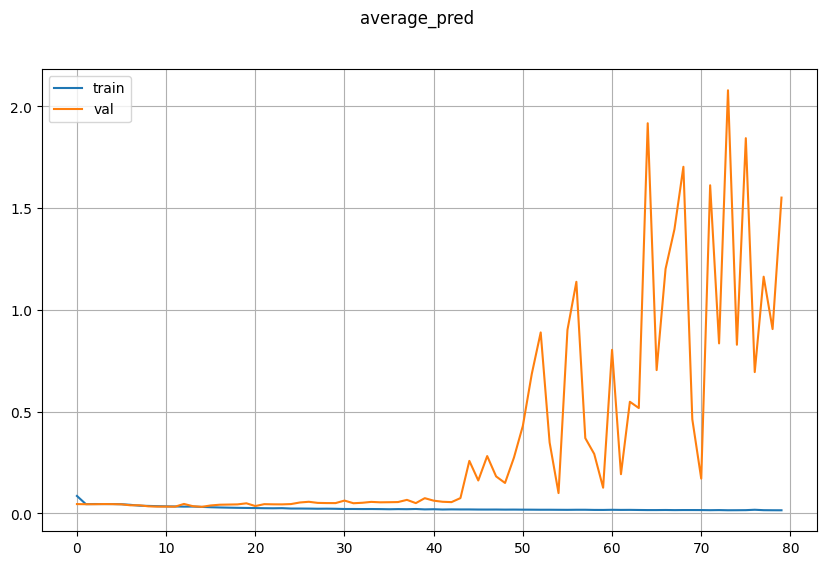

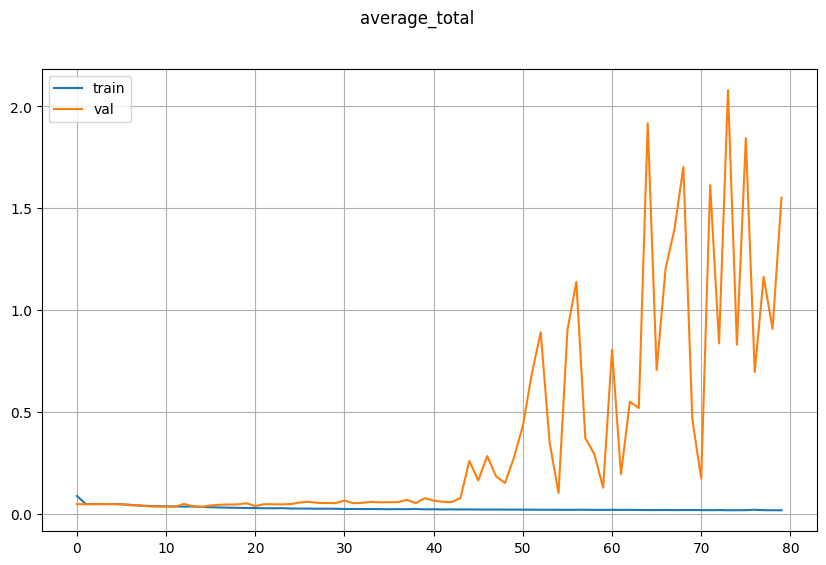

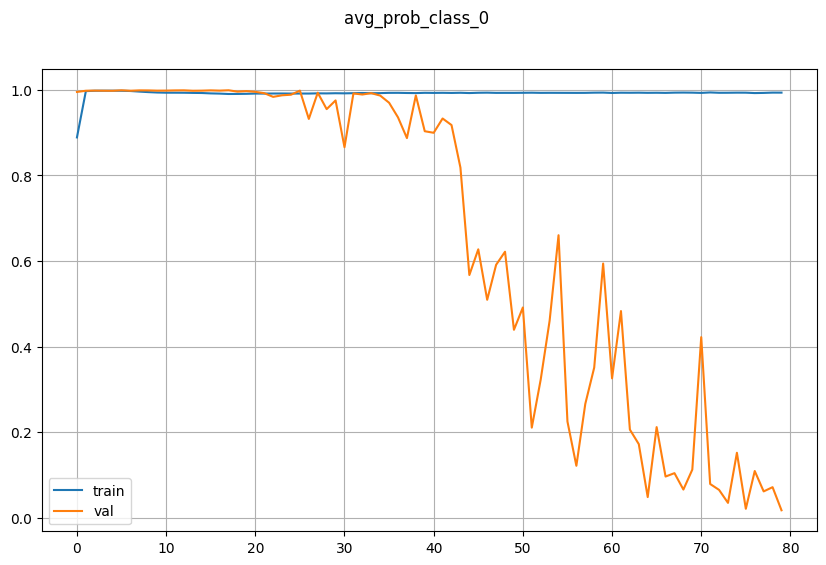

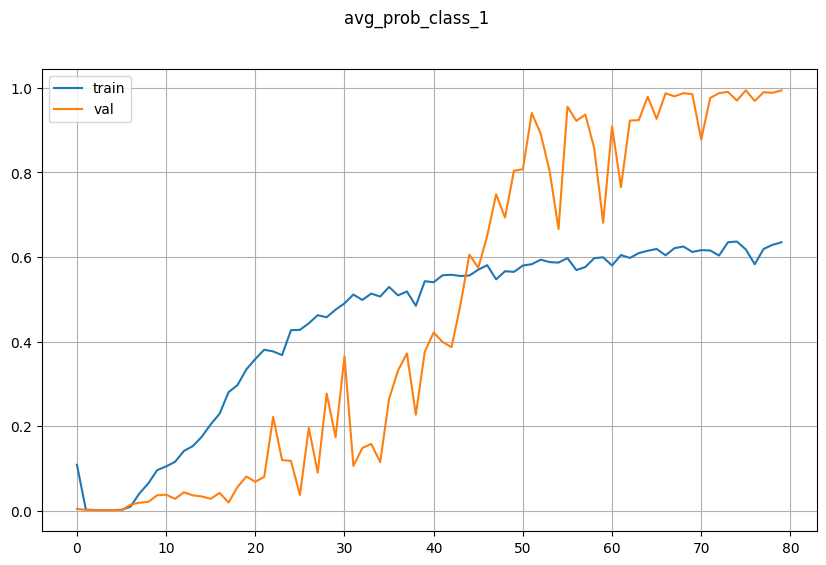

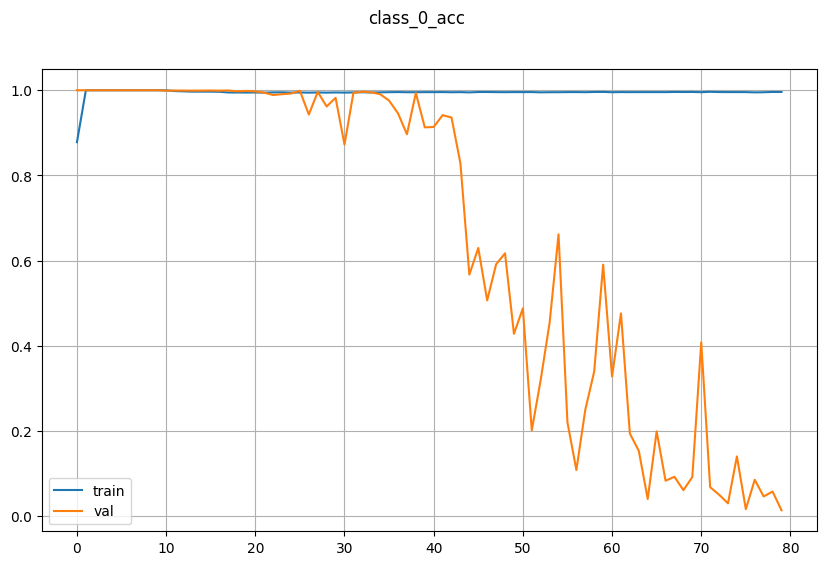

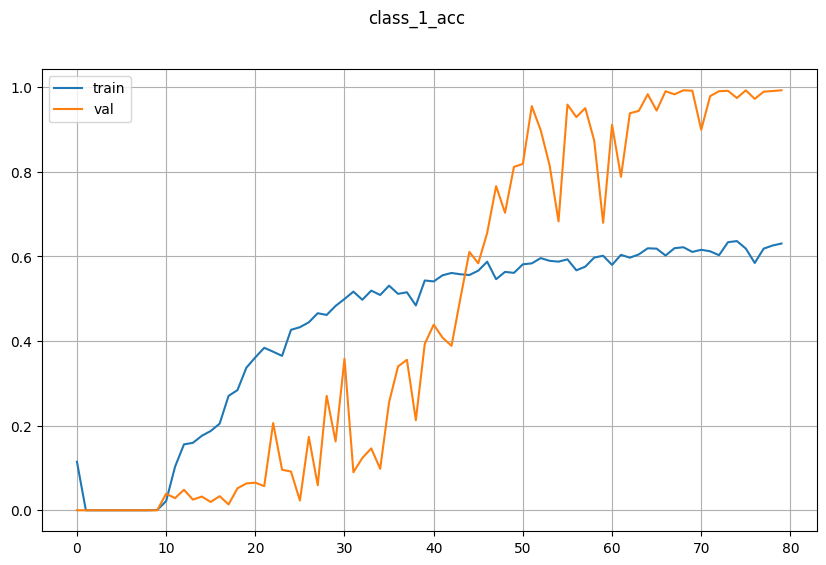

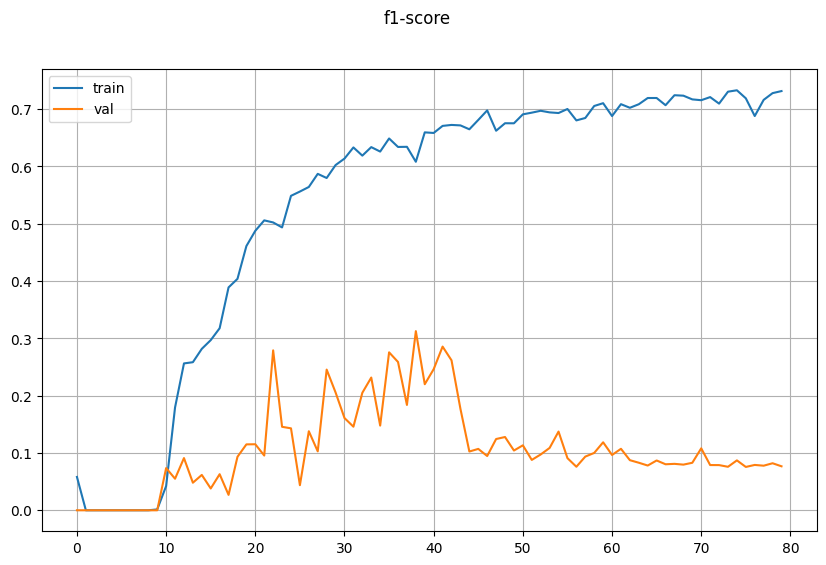

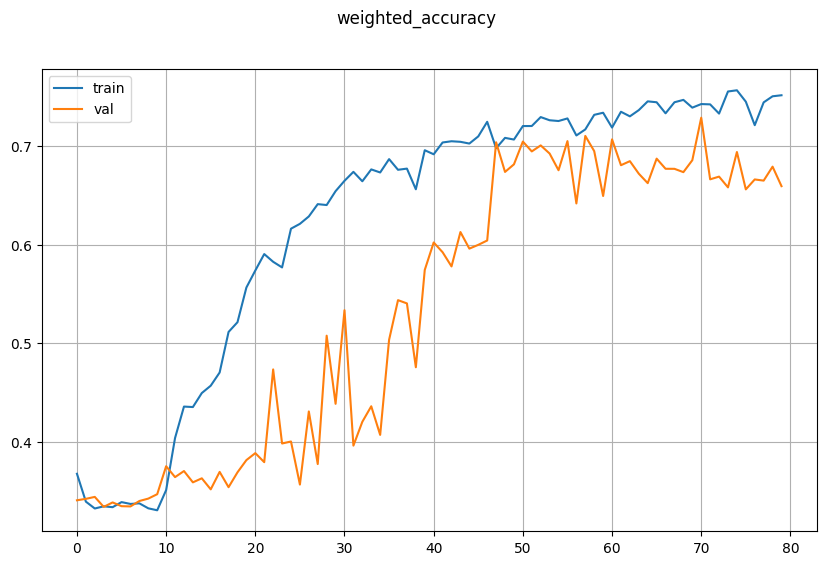

In [3]:
folder_1= "../metrics/fft - cross - standard - trans - none - none - (96 - 2%)/"
folder_2= "../metrics/fft - cross - standard - gat - none - none - VERSION_3 (2%) (BATCH 96)/"
#folder_1= ""
folder_2= ""

plot_multiple(
    folder_1=folder_1,
    folder_2=folder_2,
    show="none",
    marker=False,
    start_check=30,
    use_same_len=True,
    higher_is_better= 5*[False] + 8*[True],
    best_k=3,
    files_verbose=False
)